## 1. Environment Setup and Data Loading

Loading the preprocessed TF-IDF features from Notebook 1 for clustering analysis.

In [1]:
# Core libraries
import numpy as np
import pandas as pd
import joblib

# Clustering
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples, calinski_harabasz_score, davies_bouldin_score
from sklearn.decomposition import PCA

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# Data loading
from datasets import load_dataset

# Configuration
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Visualization settings
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print("Libraries imported successfully!")

Libraries imported successfully!


In [2]:
# Load preprocessed TF-IDF features
print("Loading preprocessed data...\n")

X_train = joblib.load('../artifacts/X_train_tfidf.joblib')
y_train = joblib.load('../artifacts/y_train.joblib')
tfidf_vectorizer = joblib.load('../artifacts/tfidf_vectorizer.joblib')

# Load original text data for interpretation
dataset = load_dataset('hpe-ai/medical-cases-classification-tutorial')
train_df = pd.DataFrame(dataset['train'])

print("Data loaded successfully!")
print(f"Feature matrix shape: {X_train.shape}")
print(f"Number of documents: {X_train.shape[0]}")
print(f"Number of TF-IDF features: {X_train.shape[1]}")
print(f"Matrix sparsity: {(1 - X_train.nnz / (X_train.shape[0] * X_train.shape[1])) * 100:.2f}%")

Loading preprocessed data...



Repo card metadata block was not found. Setting CardData to empty.


Data loaded successfully!
Feature matrix shape: (1724, 10000)
Number of documents: 1724
Number of TF-IDF features: 10000
Matrix sparsity: 97.73%


## 2. Determining Optimal Number of Clusters

Using multiple methods to identify the optimal number of clusters (k) for our data:
- **Elbow Method**: Looks for the "elbow" in within-cluster sum of squares (inertia)
- **Silhouette Analysis**: Measures how similar documents are to their own cluster vs other clusters
- **Calinski-Harabasz Index**: Ratio of between-cluster to within-cluster variance
- **Davies-Bouldin Index**: Average similarity between clusters (lower is better)

In [3]:
# Test different numbers of clusters
k_range = range(2, 21)  # Test from 2 to 20 clusters

inertias = []
silhouette_scores = []
calinski_scores = []
davies_bouldin_scores = []

print("Testing different numbers of clusters...")
print("This may take a few minutes...\n")

for k in k_range:
    # Fit K-Means
    kmeans = KMeans(n_clusters=k, random_state=RANDOM_STATE, n_init=10, max_iter=300)
    cluster_labels = kmeans.fit_predict(X_train)
    
    # Calculate metrics
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_train, cluster_labels, sample_size=1000))
    calinski_scores.append(calinski_harabasz_score(X_train.toarray(), cluster_labels))
    davies_bouldin_scores.append(davies_bouldin_score(X_train.toarray(), cluster_labels))
    
    if k % 5 == 0:
        print(f"  Completed k={k}")

print("\nCluster optimization complete!")

Testing different numbers of clusters...
This may take a few minutes...

  Completed k=5
  Completed k=10
  Completed k=15
  Completed k=20

Cluster optimization complete!


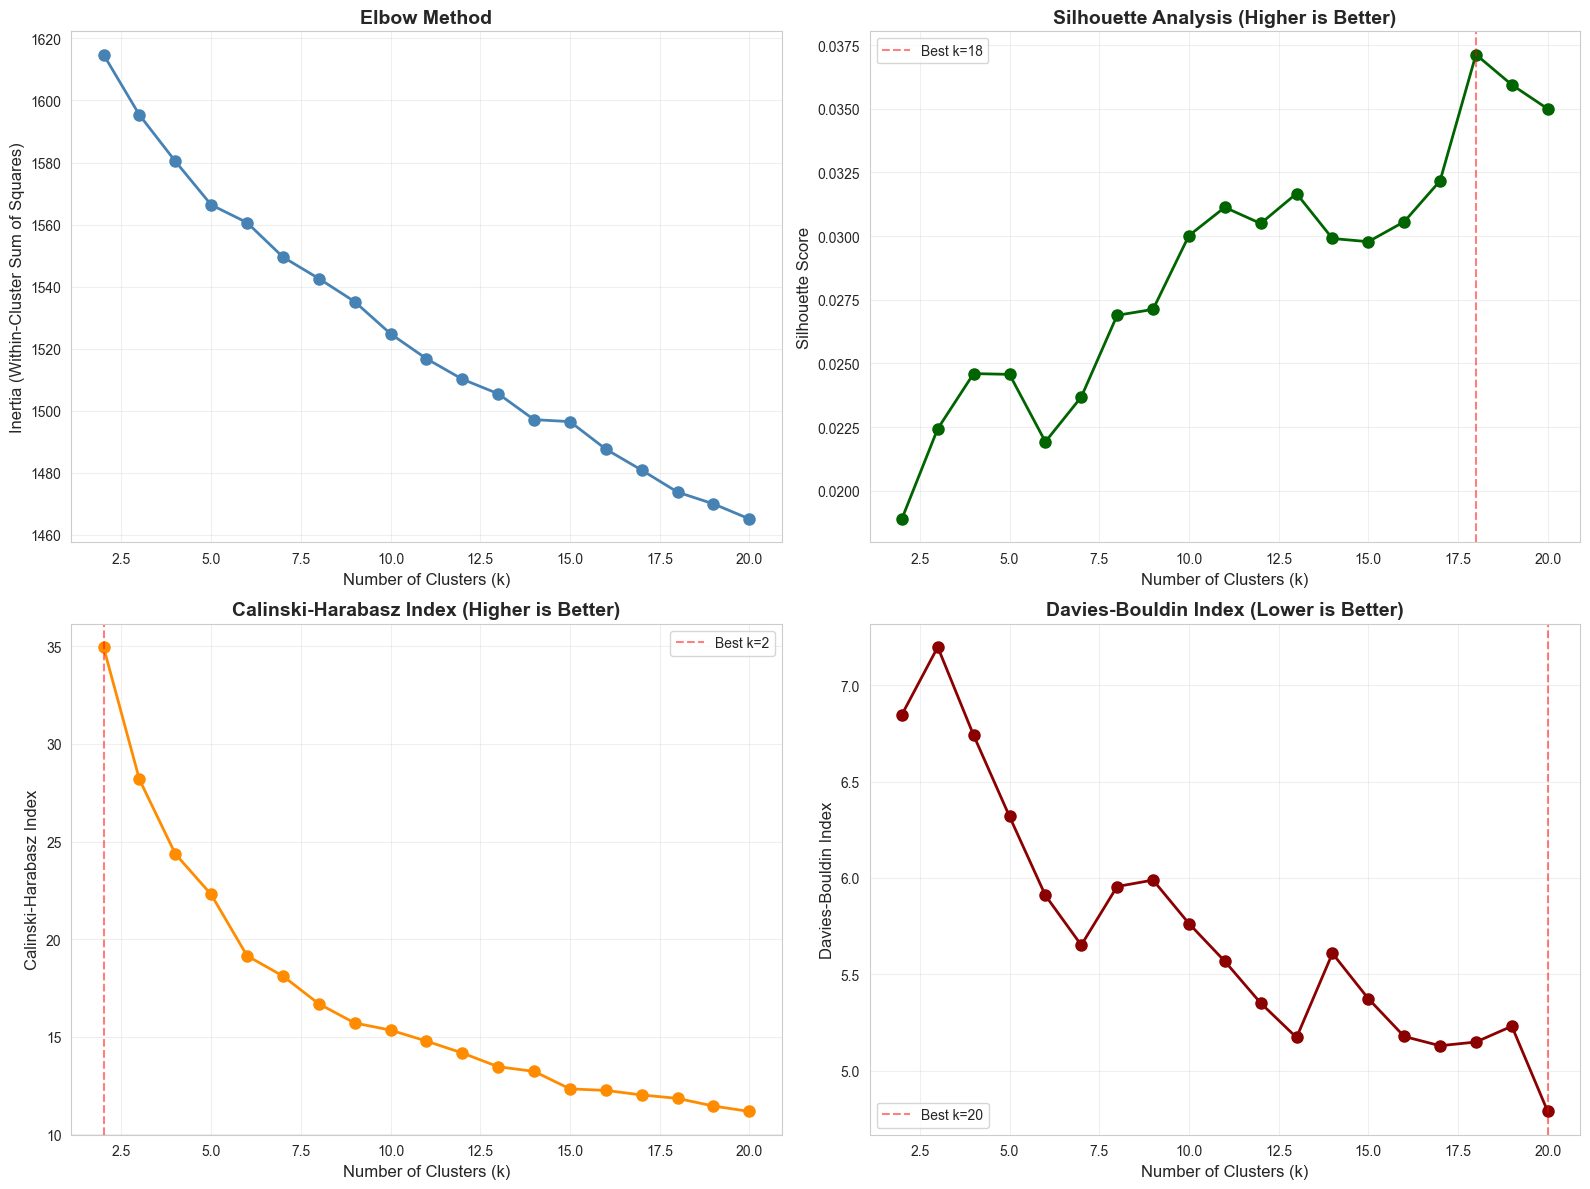


Optimal k by different metrics:
Silhouette Score suggests: k = 18
Calinski-Harabasz suggests: k = 2
Davies-Bouldin suggests: k = 20


In [4]:
# Visualize clustering metrics
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Elbow Method
axes[0, 0].plot(k_range, inertias, marker='o', linewidth=2, markersize=8, color='steelblue')
axes[0, 0].set_xlabel('Number of Clusters (k)', fontsize=12)
axes[0, 0].set_ylabel('Inertia (Within-Cluster Sum of Squares)', fontsize=12)
axes[0, 0].set_title('Elbow Method', fontsize=14, fontweight='bold')
axes[0, 0].grid(alpha=0.3)

# Silhouette Score
axes[0, 1].plot(k_range, silhouette_scores, marker='o', linewidth=2, markersize=8, color='darkgreen')
axes[0, 1].set_xlabel('Number of Clusters (k)', fontsize=12)
axes[0, 1].set_ylabel('Silhouette Score', fontsize=12)
axes[0, 1].set_title('Silhouette Analysis (Higher is Better)', fontsize=14, fontweight='bold')
axes[0, 1].grid(alpha=0.3)
best_silhouette_k = k_range[np.argmax(silhouette_scores)]
axes[0, 1].axvline(best_silhouette_k, color='red', linestyle='--', alpha=0.5, label=f'Best k={best_silhouette_k}')
axes[0, 1].legend()

# Calinski-Harabasz Index
axes[1, 0].plot(k_range, calinski_scores, marker='o', linewidth=2, markersize=8, color='darkorange')
axes[1, 0].set_xlabel('Number of Clusters (k)', fontsize=12)
axes[1, 0].set_ylabel('Calinski-Harabasz Index', fontsize=12)
axes[1, 0].set_title('Calinski-Harabasz Index (Higher is Better)', fontsize=14, fontweight='bold')
axes[1, 0].grid(alpha=0.3)
best_calinski_k = k_range[np.argmax(calinski_scores)]
axes[1, 0].axvline(best_calinski_k, color='red', linestyle='--', alpha=0.5, label=f'Best k={best_calinski_k}')
axes[1, 0].legend()

# Davies-Bouldin Index
axes[1, 1].plot(k_range, davies_bouldin_scores, marker='o', linewidth=2, markersize=8, color='darkred')
axes[1, 1].set_xlabel('Number of Clusters (k)', fontsize=12)
axes[1, 1].set_ylabel('Davies-Bouldin Index', fontsize=12)
axes[1, 1].set_title('Davies-Bouldin Index (Lower is Better)', fontsize=14, fontweight='bold')
axes[1, 1].grid(alpha=0.3)
best_db_k = k_range[np.argmin(davies_bouldin_scores)]
axes[1, 1].axvline(best_db_k, color='red', linestyle='--', alpha=0.5, label=f'Best k={best_db_k}')
axes[1, 1].legend()

plt.tight_layout()
plt.show()

print("\nOptimal k by different metrics:")
print("="*60)
print(f"Silhouette Score suggests: k = {best_silhouette_k}")
print(f"Calinski-Harabasz suggests: k = {best_calinski_k}")
print(f"Davies-Bouldin suggests: k = {best_db_k}")

### Selecting Optimal K

Based on the clustering metrics and business context, we'll select an appropriate number of clusters.

In [5]:
# Select optimal k (you can adjust this based on the plots above)
# We'll use a combination of metrics and domain knowledge
# Since we have 13 medical specialties, exploring k around 10-15 makes sense

optimal_k = best_silhouette_k  # Using silhouette score recommendation

print(f"Selected optimal number of clusters: k = {optimal_k}")
print(f"\nRationale:")
print(f"  - Silhouette score: {silhouette_scores[optimal_k-2]:.4f}")
print(f"  - Balances cluster quality with interpretability")
print(f"  - Allows discovery of meaningful document groups")

Selected optimal number of clusters: k = 18

Rationale:
  - Silhouette score: 0.0371
  - Balances cluster quality with interpretability
  - Allows discovery of meaningful document groups


## 3. Training Final K-Means Model

Fitting the K-Means algorithm with the optimal number of clusters.

In [6]:
# Train final K-Means model
print(f"Training K-Means with k={optimal_k} clusters...\n")

final_kmeans = KMeans(
    n_clusters=optimal_k,
    random_state=RANDOM_STATE,
    n_init=20,           # Run algorithm 20 times with different initializations
    max_iter=500,        # Maximum iterations per run
    algorithm='lloyd',   # Standard K-Means algorithm
    verbose=0
)

# Fit and predict cluster labels
cluster_labels = final_kmeans.fit_predict(X_train)

print("K-Means clustering complete!")
print("="*60)
print(f"Number of iterations: {final_kmeans.n_iter_}")
print(f"Final inertia: {final_kmeans.inertia_:.2f}")

# Calculate final clustering metrics
final_silhouette = silhouette_score(X_train, cluster_labels, sample_size=1000)
final_calinski = calinski_harabasz_score(X_train.toarray(), cluster_labels)
final_davies = davies_bouldin_score(X_train.toarray(), cluster_labels)

print(f"\nClustering Quality Metrics:")
print(f"  Silhouette Score: {final_silhouette:.4f}")
print(f"  Calinski-Harabasz Index: {final_calinski:.2f}")
print(f"  Davies-Bouldin Index: {final_davies:.4f}")

Training K-Means with k=18 clusters...

K-Means clustering complete!
Number of iterations: 11
Final inertia: 1473.77

Clustering Quality Metrics:
  Silhouette Score: 0.0368
  Calinski-Harabasz Index: 11.84
  Davies-Bouldin Index: 5.1483



Cluster Size Distribution:
Cluster 0: 67 documents (3.9%)
Cluster 1: 277 documents (16.1%)
Cluster 2: 221 documents (12.8%)
Cluster 3: 127 documents (7.4%)
Cluster 4: 97 documents (5.6%)
Cluster 5: 31 documents (1.8%)
Cluster 6: 34 documents (2.0%)
Cluster 7: 127 documents (7.4%)
Cluster 8: 161 documents (9.3%)
Cluster 9: 85 documents (4.9%)
Cluster 10: 97 documents (5.6%)
Cluster 11: 80 documents (4.6%)
Cluster 12: 29 documents (1.7%)
Cluster 13: 49 documents (2.8%)
Cluster 14: 18 documents (1.0%)
Cluster 15: 74 documents (4.3%)
Cluster 16: 100 documents (5.8%)
Cluster 17: 50 documents (2.9%)


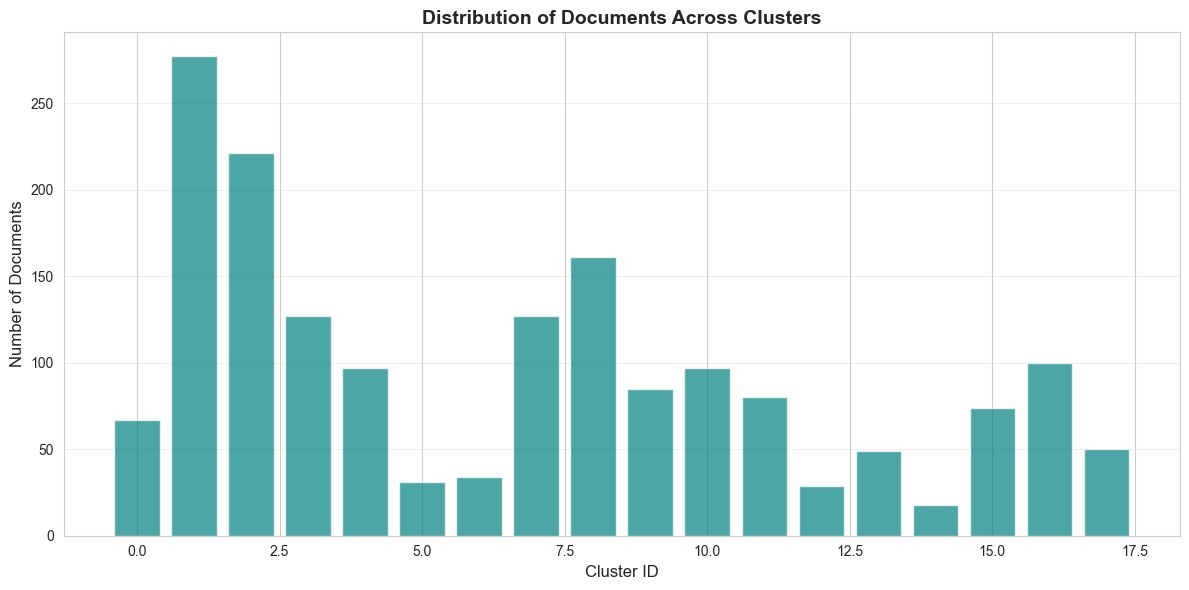

In [7]:
# Add cluster labels to dataframe
train_df['cluster'] = cluster_labels

# Analyze cluster sizes
cluster_sizes = pd.Series(cluster_labels).value_counts().sort_index()

print("\nCluster Size Distribution:")
print("="*60)
for cluster_id, size in cluster_sizes.items():
    percentage = (size / len(cluster_labels)) * 100
    print(f"Cluster {cluster_id}: {size} documents ({percentage:.1f}%)")

# Visualize cluster sizes
fig, ax = plt.subplots(figsize=(12, 6))
ax.bar(cluster_sizes.index, cluster_sizes.values, color='teal', alpha=0.7)
ax.set_xlabel('Cluster ID', fontsize=12)
ax.set_ylabel('Number of Documents', fontsize=12)
ax.set_title('Distribution of Documents Across Clusters', fontsize=14, fontweight='bold')
ax.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

## 4. Cluster Visualization using PCA

Reducing high-dimensional TF-IDF features to 2D using Principal Component Analysis for visualization.

In [8]:
# Perform PCA for visualization
print("Performing PCA dimensionality reduction for visualization...\n")

pca = PCA(n_components=2, random_state=RANDOM_STATE)
X_pca = pca.fit_transform(X_train.toarray())

print(f"PCA Complete!")
print(f"Explained variance by components: {pca.explained_variance_ratio_}")
print(f"Total variance explained: {pca.explained_variance_ratio_.sum():.4f}")

Performing PCA dimensionality reduction for visualization...

PCA Complete!
Explained variance by components: [0.02465544 0.01482984]
Total variance explained: 0.0395


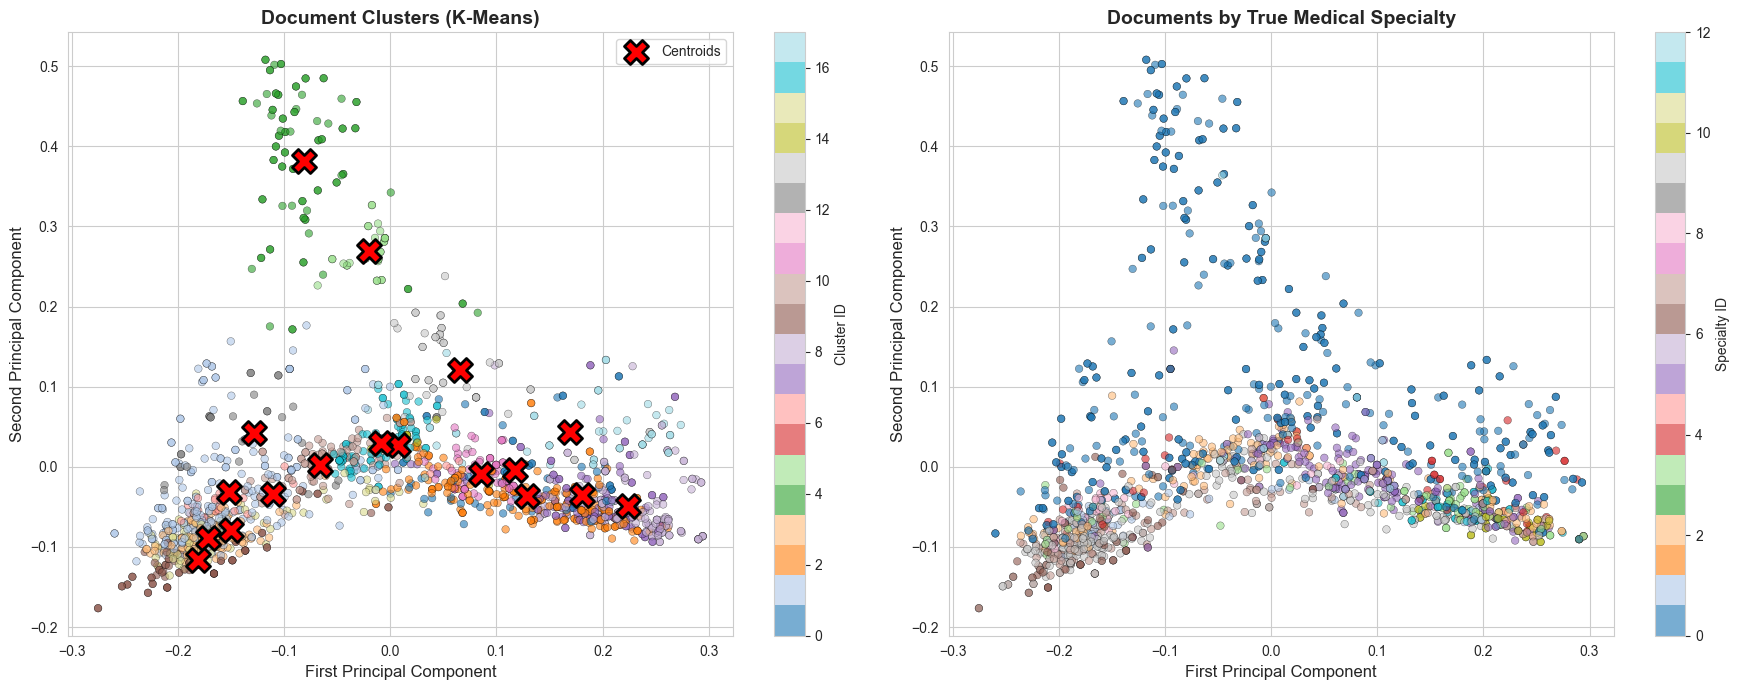


Note: The visualization shows documents projected to 2D space.
Proximity in this plot indicates similarity in the full feature space.


In [9]:
# Visualize clusters in 2D space
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# Plot 1: Colored by cluster
scatter1 = axes[0].scatter(X_pca[:, 0], X_pca[:, 1], c=cluster_labels, 
                          cmap='tab20', alpha=0.6, s=30, edgecolors='black', linewidth=0.3)
axes[0].set_xlabel('First Principal Component', fontsize=12)
axes[0].set_ylabel('Second Principal Component', fontsize=12)
axes[0].set_title('Document Clusters (K-Means)', fontsize=14, fontweight='bold')
plt.colorbar(scatter1, ax=axes[0], label='Cluster ID')

# Plot centroids
centroids_pca = pca.transform(final_kmeans.cluster_centers_)
axes[0].scatter(centroids_pca[:, 0], centroids_pca[:, 1], 
               marker='X', s=300, c='red', edgecolors='black', linewidth=2, 
               label='Centroids', zorder=5)
axes[0].legend()

# Plot 2: Colored by true medical specialty for comparison
specialty_encoded = pd.Categorical(train_df['medical_specialty']).codes
scatter2 = axes[1].scatter(X_pca[:, 0], X_pca[:, 1], c=specialty_encoded, 
                          cmap='tab20', alpha=0.6, s=30, edgecolors='black', linewidth=0.3)
axes[1].set_xlabel('First Principal Component', fontsize=12)
axes[1].set_ylabel('Second Principal Component', fontsize=12)
axes[1].set_title('Documents by True Medical Specialty', fontsize=14, fontweight='bold')
plt.colorbar(scatter2, ax=axes[1], label='Specialty ID')

plt.tight_layout()
plt.show()

print("\nNote: The visualization shows documents projected to 2D space.")
print("Proximity in this plot indicates similarity in the full feature space.")

## 5. Cluster Characterization

In [10]:
# Get feature names for interpretation
feature_names = tfidf_vectorizer.get_feature_names_out()

def get_top_terms_for_cluster(cluster_id, n_terms=15):
    """
    Extract the most important terms for a given cluster based on centroid values.
    """
    centroid = final_kmeans.cluster_centers_[cluster_id]
    top_indices = centroid.argsort()[-n_terms:][::-1]
    top_terms = [(feature_names[i], centroid[i]) for i in top_indices]
    return top_terms

print("Top Terms by Cluster:")
print("="*80)

for cluster_id in range(optimal_k):
    top_terms = get_top_terms_for_cluster(cluster_id, n_terms=10)
    cluster_size = cluster_sizes[cluster_id]
    
    print(f"\nCLUSTER {cluster_id} ({cluster_size} documents):")
    print("-" * 80)
    print("Top Terms:")
    for term, score in top_terms:
        print(f"  • {term}: {score:.4f}")

Top Terms by Cluster:

CLUSTER 0 (67 documents):
--------------------------------------------------------------------------------
Top Terms:
  • discharge: 0.0818
  • hospital course: 0.0508
  • admission: 0.0460
  • hospital: 0.0418
  • patient: 0.0404
  • course: 0.0396
  • home: 0.0384
  • day: 0.0357
  • disease: 0.0350
  • hospital course patient: 0.0346

CLUSTER 1 (277 documents):
--------------------------------------------------------------------------------
Top Terms:
  • procedure: 0.0441
  • placed: 0.0373
  • patient: 0.0359
  • diagnosis: 0.0317
  • right: 0.0314
  • incision: 0.0303
  • anesthesia: 0.0300
  • closed: 0.0273
  • left: 0.0270
  • fashion: 0.0267

CLUSTER 2 (221 documents):
--------------------------------------------------------------------------------
Top Terms:
  • history: 0.0375
  • patient: 0.0330
  • pain: 0.0319
  • does: 0.0291
  • symptoms: 0.0277
  • past: 0.0269
  • time: 0.0249
  • medications: 0.0242
  • medical: 0.0240
  • examination: 0.0227


## 6. Cluster-Specialty Relationship Analysis

Examining how clusters align with the true medical specialties.

Cluster-Specialty Cross-Tabulation:
medical_specialty  Cardiovascular / Pulmonary  ENT - Otolaryngology  \
cluster                                                               
0                                          32                     0   
1                                         111                    32   
2                                           8                     8   
3                                           0                     0   
4                                          96                     0   
5                                          29                     0   
6                                           0                     0   
7                                          31                     5   
8                                          38                     3   
9                                           0                     0   
10                                         47                     5   
11                                       

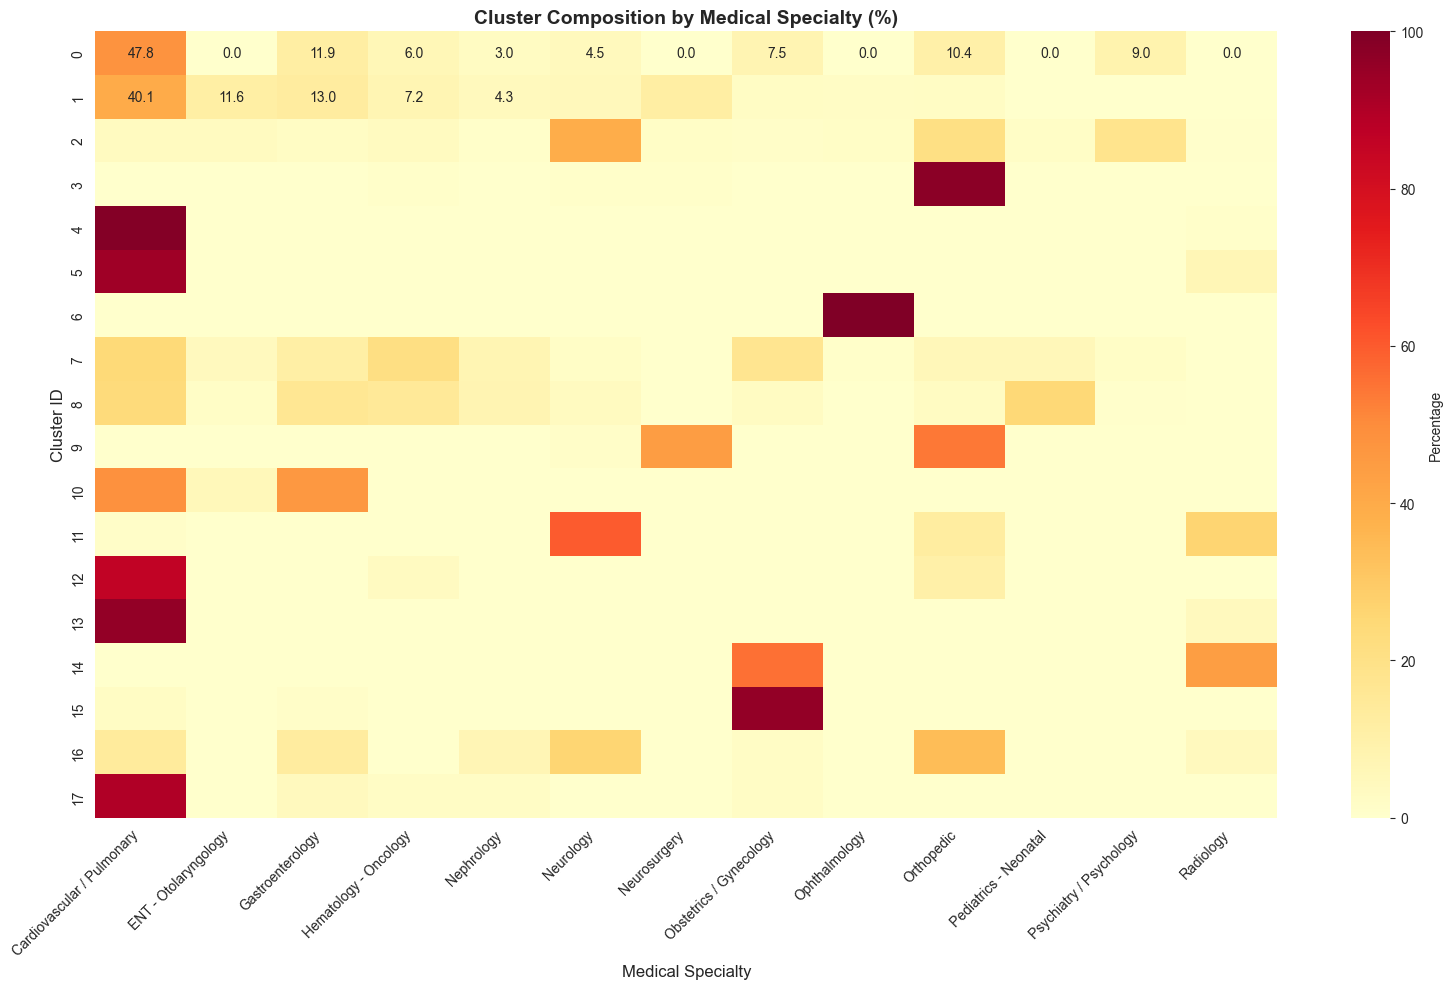

In [11]:
# Create cross-tabulation of clusters vs specialties
cluster_specialty_crosstab = pd.crosstab(
    train_df['cluster'], 
    train_df['medical_specialty'],
    margins=True
)

print("Cluster-Specialty Cross-Tabulation:")
print("="*80)
print(cluster_specialty_crosstab)

# Visualize as heatmap
fig, ax = plt.subplots(figsize=(16, 10))
cluster_specialty_crosstab_pct = pd.crosstab(
    train_df['cluster'], 
    train_df['medical_specialty'],
    normalize='index'
) * 100

sns.heatmap(cluster_specialty_crosstab_pct, annot=True, fmt='.1f', cmap='YlOrRd', 
            cbar_kws={'label': 'Percentage'}, ax=ax)
ax.set_xlabel('Medical Specialty', fontsize=12)
ax.set_ylabel('Cluster ID', fontsize=12)
ax.set_title('Cluster Composition by Medical Specialty (%)', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [12]:
# Identify dominant specialty for each cluster
print("\n\nDominant Medical Specialty per Cluster:")
print("="*80)

for cluster_id in range(optimal_k):
    cluster_docs = train_df[train_df['cluster'] == cluster_id]
    specialty_counts = cluster_docs['medical_specialty'].value_counts()
    
    print(f"\nCluster {cluster_id} ({len(cluster_docs)} documents):")
    print("-" * 80)
    
    # Show top 3 specialties in this cluster
    for i, (specialty, count) in enumerate(specialty_counts.head(3).items(), 1):
        percentage = (count / len(cluster_docs)) * 100
        print(f"  {i}. {specialty}: {count} docs ({percentage:.1f}%)")
    
    # Calculate purity (homogeneity)
    purity = specialty_counts.iloc[0] / len(cluster_docs)
    if purity > 0.7:
        print(f"  → High purity cluster ({purity:.1%}) - strongly associated with {specialty_counts.index[0]}")
    elif purity > 0.4:
        print(f"  → Moderate purity cluster ({purity:.1%}) - mixed specialties")
    else:
        print(f"  → Low purity cluster ({purity:.1%}) - diverse mix of specialties")



Dominant Medical Specialty per Cluster:

Cluster 0 (67 documents):
--------------------------------------------------------------------------------
  1. Cardiovascular / Pulmonary: 32 docs (47.8%)
  2. Gastroenterology: 8 docs (11.9%)
  3. Orthopedic: 7 docs (10.4%)
  → Moderate purity cluster (47.8%) - mixed specialties

Cluster 1 (277 documents):
--------------------------------------------------------------------------------
  1. Cardiovascular / Pulmonary: 111 docs (40.1%)
  2. Gastroenterology: 36 docs (13.0%)
  3. Neurosurgery: 33 docs (11.9%)
  → Moderate purity cluster (40.1%) - mixed specialties

Cluster 2 (221 documents):
--------------------------------------------------------------------------------
  1. Neurology: 87 docs (39.4%)
  2. Orthopedic: 46 docs (20.8%)
  3. Psychiatry / Psychology: 40 docs (18.1%)
  → Low purity cluster (39.4%) - diverse mix of specialties

Cluster 3 (127 documents):
------------------------------------------------------------------------------

## 7. Detailed Cluster Profiles with Word Clouds

Creating word clouds for each cluster to visualize the most prominent terms.

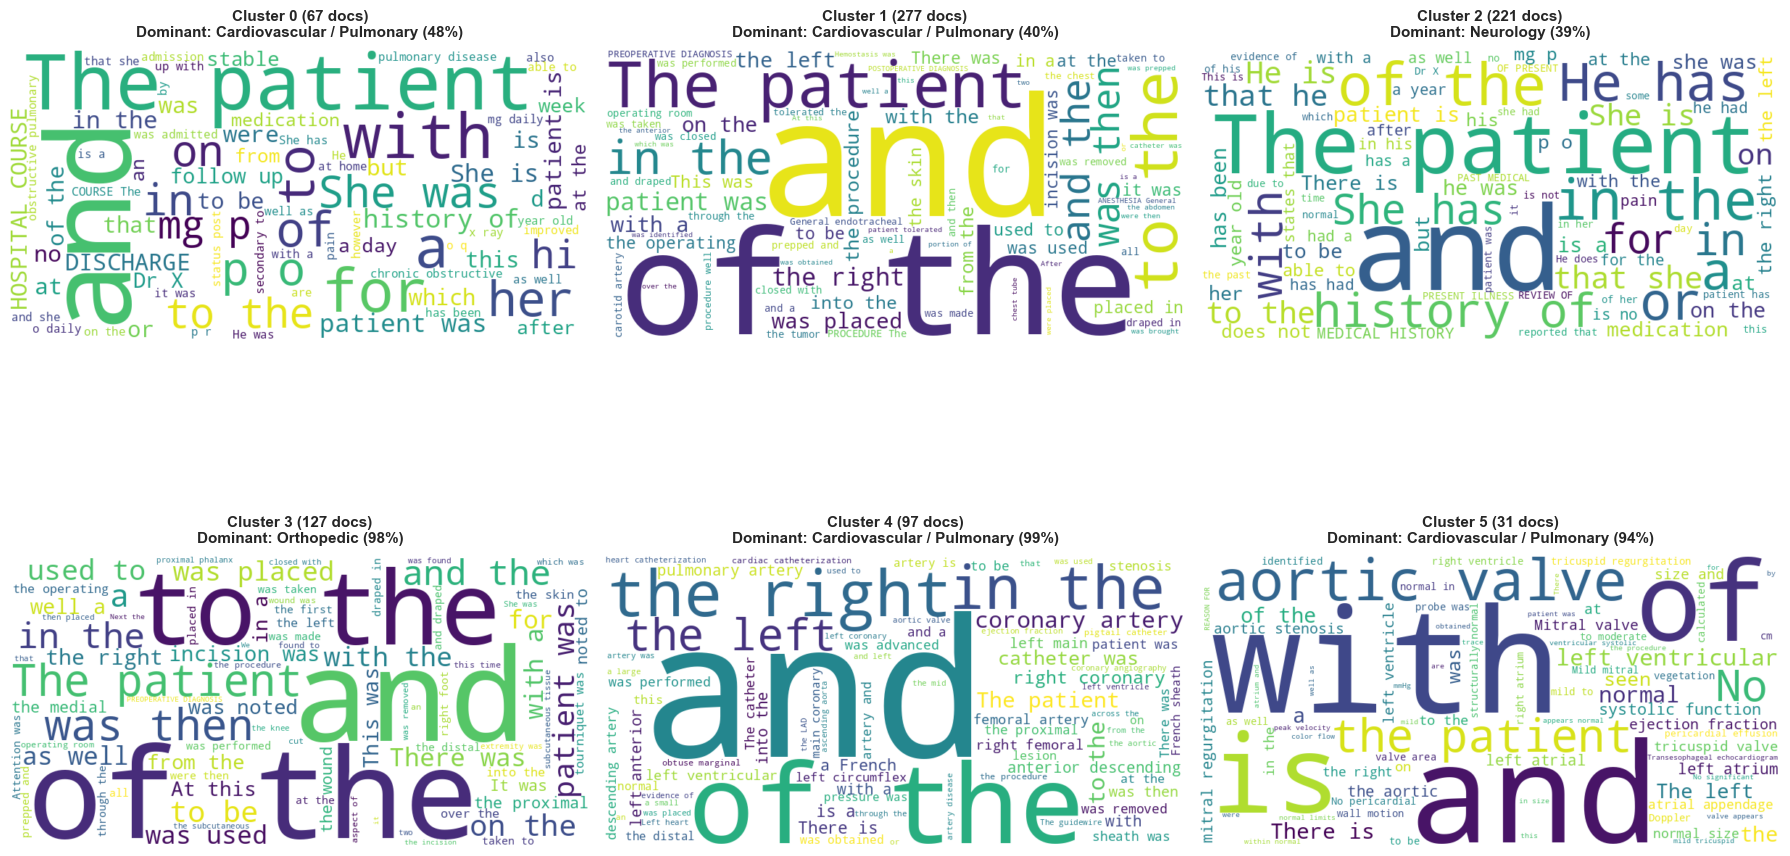

In [13]:
# Generate word clouds for first 6 clusters (adjust if you want more)
n_clusters_to_visualize = min(6, optimal_k)
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for i in range(n_clusters_to_visualize):
    cluster_docs = train_df[train_df['cluster'] == i]
    cluster_text = ' '.join(cluster_docs['transcription'].astype(str))
    
    # Generate word cloud
    wordcloud = WordCloud(
        width=800, 
        height=400,
        background_color='white',
        stopwords='english',
        colormap='viridis',
        max_words=80
    ).generate(cluster_text)
    
    axes[i].imshow(wordcloud, interpolation='bilinear')
    axes[i].axis('off')
    
    # Get dominant specialty for title
    dominant_specialty = cluster_docs['medical_specialty'].value_counts().index[0]
    dominant_pct = (cluster_docs['medical_specialty'].value_counts().iloc[0] / len(cluster_docs)) * 100
    
    axes[i].set_title(
        f'Cluster {i} ({len(cluster_docs)} docs)\nDominant: {dominant_specialty} ({dominant_pct:.0f}%)',
        fontsize=11, fontweight='bold', pad=10
    )

plt.tight_layout()
plt.show()

## 8. Sample Documents from Each Cluster

Examining representative documents to understand cluster themes.

In [14]:
# Show sample documents from first 3 clusters
print("Sample Documents from Clusters:")
print("="*80)

for cluster_id in range(min(3, optimal_k)):
    cluster_docs = train_df[train_df['cluster'] == cluster_id]
    sample_doc = cluster_docs.iloc[0]
    
    print(f"\n\nCLUSTER {cluster_id} - Sample Document:")
    print("-" * 80)
    print(f"Medical Specialty: {sample_doc['medical_specialty']}")
    print(f"Description: {sample_doc['description']}")
    print(f"\nTranscription (first 400 characters):")
    print(sample_doc['transcription'][:400] + "...")
    print("\n" + "="*80)

Sample Documents from Clusters:


CLUSTER 0 - Sample Document:
--------------------------------------------------------------------------------
Medical Specialty: Cardiovascular / Pulmonary
Description: Bronchiolitis, respiratory syncytial virus positive; improved and stable.  Innocent heart murmur, stable.

Transcription (first 400 characters):
DIAGNOSES:,1.  Bronchiolitis, respiratory syncytial virus positive; improved and stable.,2.  Innocent heart murmur, stable.,HOSPITAL COURSE: , The patient was admitted for an acute onset of congestion.  She was checked for RSV, which was positive and admitted to the hospital for acute bronchiolitis.  She has always been stable on room air; however, because of her age and her early diagnosis, she w...



CLUSTER 1 - Sample Document:
--------------------------------------------------------------------------------
Medical Specialty: Orthopedic
Description: Erythema of the right knee and leg, possible septic knee. Aspiration through the anterolater

## 9. Silhouette Analysis by Cluster

Evaluating the quality of individual clusters using silhouette scores.

In [15]:
# Calculate silhouette scores for each sample
sample_silhouette_values = silhouette_samples(X_train, cluster_labels)

# Calculate average silhouette score per cluster
cluster_silhouette_scores = []
for i in range(optimal_k):
    cluster_silhouette = sample_silhouette_values[cluster_labels == i].mean()
    cluster_silhouette_scores.append(cluster_silhouette)

# Create DataFrame for better display
silhouette_df = pd.DataFrame({
    'Cluster': range(optimal_k),
    'Silhouette Score': cluster_silhouette_scores,
    'Size': [cluster_sizes[i] for i in range(optimal_k)]
}).sort_values('Silhouette Score', ascending=False)

print("Silhouette Scores by Cluster:")
print("="*60)
print(silhouette_df.to_string(index=False))
print(f"\nOverall Average Silhouette Score: {final_silhouette:.4f}")

Silhouette Scores by Cluster:
 Cluster  Silhouette Score  Size
      14          0.319207    18
       5          0.155527    31
       6          0.092300    34
      11          0.087325    80
      13          0.086551    49
      12          0.083033    29
       4          0.081543    97
       9          0.070834    85
      15          0.051659    74
      17          0.047782    50
       3          0.032491   127
      10          0.027404    97
      16          0.022583   100
       8          0.022274   161
       0          0.014745    67
       7          0.006311   127
       2          0.002866   221
       1         -0.000721   277

Overall Average Silhouette Score: 0.0368


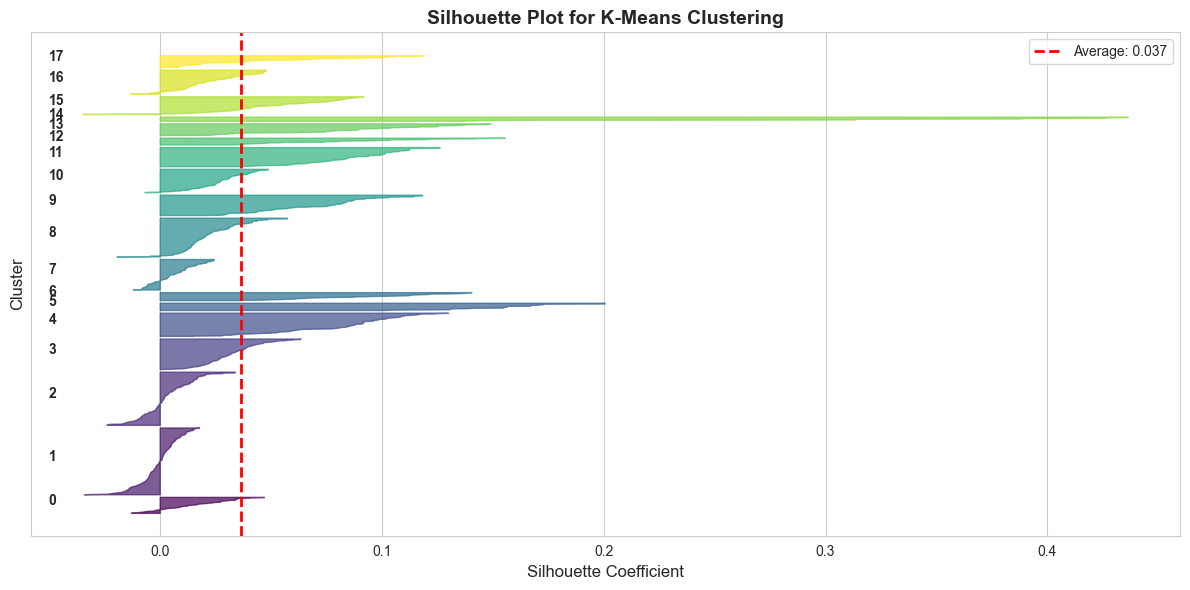


Interpretation:
  - Values near 1.0 indicate well-separated clusters
  - Values near 0 indicate overlapping clusters
  - Negative values indicate potential misclassification


In [16]:
# Visualize silhouette scores
fig, ax = plt.subplots(figsize=(12, 6))

colors = plt.cm.viridis(np.linspace(0, 1, optimal_k))
y_lower = 10

for i in range(optimal_k):
    # Get silhouette values for this cluster
    cluster_silhouette_vals = sample_silhouette_values[cluster_labels == i]
    cluster_silhouette_vals.sort()
    
    size_cluster = cluster_silhouette_vals.shape[0]
    y_upper = y_lower + size_cluster
    
    ax.fill_betweenx(np.arange(y_lower, y_upper),
                     0, cluster_silhouette_vals,
                     facecolor=colors[i], edgecolor=colors[i], alpha=0.7)
    
    # Label the silhouette plots with cluster numbers
    ax.text(-0.05, y_lower + 0.5 * size_cluster, str(i), fontsize=10, fontweight='bold')
    
    y_lower = y_upper + 10

ax.set_xlabel('Silhouette Coefficient', fontsize=12)
ax.set_ylabel('Cluster', fontsize=12)
ax.set_title('Silhouette Plot for K-Means Clustering', fontsize=14, fontweight='bold')
ax.axvline(x=final_silhouette, color='red', linestyle='--', linewidth=2, label=f'Average: {final_silhouette:.3f}')
ax.set_yticks([])
ax.legend()
plt.tight_layout()
plt.show()

print("\nInterpretation:")
print("  - Values near 1.0 indicate well-separated clusters")
print("  - Values near 0 indicate overlapping clusters")
print("  - Negative values indicate potential misclassification")

## 10. Business Insights and Applications

Interpreting clustering results in the context of MedArchive Solutions' operational needs.

In [17]:
print("\n" + "="*80)
print("BUSINESS INSIGHTS FROM CLUSTERING ANALYSIS")
print("="*80)

# Insight 1: Document type discovery
print("\n1. DISCOVERED DOCUMENT TYPES:")
print("-" * 80)

for cluster_id in range(optimal_k):
    cluster_docs = train_df[train_df['cluster'] == cluster_id]
    top_terms = get_top_terms_for_cluster(cluster_id, n_terms=5)
    dominant_specialty = cluster_docs['medical_specialty'].value_counts().index[0]
    
    # Identify cluster theme based on top terms
    top_term_list = [term for term, _ in top_terms]
    
    print(f"\nCluster {cluster_id}:")
    print(f"  Primary theme: {', '.join(top_term_list[:3])}")
    print(f"  Main specialty: {dominant_specialty}")
    print(f"  Document count: {len(cluster_docs)}")

# Insight 2: Sub-specialty detection
print("\n\n2. SUB-SPECIALTY DETECTION:")
print("-" * 80)
print("Clusters can reveal sub-specialties within broader medical categories.")
print("Example applications:")
print("  • Routing documents to specific sub-departments")
print("  • Identifying specialized procedures requiring specific expertise")
print("  • Optimizing staffing based on document type volumes")

# Insight 3: Quality control
print("\n\n3. QUALITY CONTROL OPPORTUNITIES:")
print("-" * 80)

# Find mixed clusters (low purity)
mixed_clusters = []
for cluster_id in range(optimal_k):
    cluster_docs = train_df[train_df['cluster'] == cluster_id]
    specialty_counts = cluster_docs['medical_specialty'].value_counts()
    purity = specialty_counts.iloc[0] / len(cluster_docs)
    
    if purity < 0.5:  # Mixed cluster
        mixed_clusters.append((cluster_id, purity, len(cluster_docs)))

if mixed_clusters:
    print("Mixed clusters identified (multiple specialties):")
    for cluster_id, purity, size in mixed_clusters:
        print(f"  • Cluster {cluster_id}: {size} documents, purity {purity:.1%}")
        print(f"    → May contain documents requiring multi-disciplinary review")
else:
    print("All clusters show strong specialty associations.")

# Insight 4: Operational recommendations
print("\n\n4. OPERATIONAL RECOMMENDATIONS:")
print("-" * 80)
print("  ✓ Use clusters to identify common document templates")
print("  ✓ Optimize routing workflows based on cluster patterns")
print("  ✓ Create specialized processing queues for high-volume clusters")
print("  ✓ Monitor cluster drift over time to detect changing patterns")
print("  ✓ Use cluster membership as an additional feature for classification")

# Insight 5: Model enhancement
print("\n\n5. ENHANCING THE CLASSIFICATION MODEL:")
print("-" * 80)
print("Cluster information can improve the supervised model:")
print("  • Add cluster ID as a feature to the classification model")
print("  • Use cluster-specific classifiers for better accuracy")
print("  • Identify outliers (documents far from cluster centers)")
print("  • Flag ambiguous cases for human review based on cluster uncertainty")


BUSINESS INSIGHTS FROM CLUSTERING ANALYSIS

1. DISCOVERED DOCUMENT TYPES:
--------------------------------------------------------------------------------

Cluster 0:
  Primary theme: discharge, hospital course, admission
  Main specialty: Cardiovascular / Pulmonary
  Document count: 67

Cluster 1:
  Primary theme: procedure, placed, patient
  Main specialty: Cardiovascular / Pulmonary
  Document count: 277

Cluster 2:
  Primary theme: history, patient, pain
  Main specialty: Neurology
  Document count: 221

Cluster 3:
  Primary theme: tourniquet, placed, anesthesia
  Main specialty: Orthopedic
  Document count: 127

Cluster 4:
  Primary theme: coronary, artery, right coronary
  Main specialty: Cardiovascular / Pulmonary
  Document count: 97

Cluster 5:
  Primary theme: valve, aortic, mitral
  Main specialty: Cardiovascular / Pulmonary
  Document count: 31

Cluster 6:
  Primary theme: eye, anterior chamber, chamber
  Main specialty: Ophthalmology
  Document count: 34

Cluster 7:
  Pri

## 11. Cluster Stability Analysis

Assessing how stable the clusters are by comparing results from multiple random initializations.

In [19]:
# Run K-Means multiple times with different random seeds
n_runs = 5
stability_scores = []

print(f"Testing cluster stability across {n_runs} runs...\n")

for run in range(n_runs):
    km = KMeans(n_clusters=optimal_k, random_state=run, n_init=10)
    labels = km.fit_predict(X_train)
    silhouette = silhouette_score(X_train, labels, sample_size=1000)
    stability_scores.append(silhouette)
    print(f"Run {run+1}: Silhouette Score = {silhouette:.4f}")

mean_score = np.mean(stability_scores)
std_score = np.std(stability_scores)

print(f"\nStability Analysis:")
print("="*60)
print(f"Mean Silhouette Score: {mean_score:.4f}")
print(f"Standard Deviation: {std_score:.4f}")
print(f"Coefficient of Variation: {(std_score/mean_score)*100:.2f}%")

if std_score < 0.01:
    print("\n✓ Clusters are highly stable across different initializations.")
elif std_score < 0.05:
    print("\n✓ Clusters show good stability with minor variations.")
else:
    print("\n⚠️  Clusters show significant variation - consider different k or algorithm.")

Testing cluster stability across 5 runs...

Run 1: Silhouette Score = 0.0358
Run 2: Silhouette Score = 0.0375
Run 3: Silhouette Score = 0.0365
Run 4: Silhouette Score = 0.0336
Run 5: Silhouette Score = 0.0313

Stability Analysis:
Mean Silhouette Score: 0.0349
Standard Deviation: 0.0022
Coefficient of Variation: 6.32%

✓ Clusters are highly stable across different initializations.


## 12. Saving Clustering Results

Saving the trained K-Means model and cluster assignments for future analysis.

In [21]:
# Save clustering model
clustering_artifacts_path = '../artifacts/kmeans_model.joblib'
joblib.dump(final_kmeans, clustering_artifacts_path)
print(f"K-Means model saved to: {clustering_artifacts_path}")

# Save cluster assignments
cluster_assignments = train_df[['sample_name', 'medical_specialty', 'cluster']].copy()
cluster_assignments_path = '../artifacts/cluster_assignments.csv'
cluster_assignments.to_csv(cluster_assignments_path, index=False)
print(f"Cluster assignments saved to: {cluster_assignments_path}")

# Save clustering summary
clustering_summary = {
    'optimal_k': optimal_k,
    'silhouette_score': final_silhouette,
    'calinski_harabasz_score': final_calinski,
    'davies_bouldin_score': final_davies,
    'inertia': final_kmeans.inertia_,
    'n_iter': final_kmeans.n_iter_
}

summary_df = pd.DataFrame([clustering_summary])
summary_path = '../artifacts/clustering_summary.csv'
summary_df.to_csv(summary_path, index=False)
print(f"Clustering summary saved to: {summary_path}")

print("\n✓ All clustering artifacts saved successfully!")

K-Means model saved to: ../artifacts/kmeans_model.joblib
Cluster assignments saved to: ../artifacts/cluster_assignments.csv
Clustering summary saved to: ../artifacts/clustering_summary.csv

✓ All clustering artifacts saved successfully!
